# Prise de connaissance des variables "Comment", "ComplianceStatus" pour éclaircir le dataset

1. Comment
2. ComplianceStatus


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datas = pd.read_csv("Pélec_02_nettoyage_global.csv")
datas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   OSEBuildingID                   1642 non-null   int64  
 1   DataYear                        1642 non-null   int64  
 2   PrimaryPropertyType             1642 non-null   object 
 3   CouncilDistrictCode             1642 non-null   int64  
 4   YearBuilt                       1642 non-null   int64  
 5   NumberofBuildings               1642 non-null   float64
 6   NumberofFloors                  1634 non-null   float64
 7   PropertyGFATotal                1642 non-null   int64  
 8   PropertyGFAParking              1642 non-null   int64  
 9   PropertyGFABuilding(s)          1642 non-null   int64  
 10  ENERGYSTARScore                 1111 non-null   float64
 11  SiteEUI(kBtu/sf)                1635 non-null   float64
 12  SiteEUIWN(kBtu/sf)              16

# 1. Comment

In [2]:
commentaires = datas[datas["Comment"].notna()][["DataYear", "Comment"]]

for i in commentaires.index:
    print(f"Index: {i}, Year: {commentaires.loc[i, 'DataYear']}\n{commentaires.loc[i, 'Comment']}")


Index: 61, Year: 2015
Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1948 to 2016.
Index: 427, Year: 2015
Part of McKinstry's campus, property operates a fabrication and production shop and is conditioned by natural gas overhead radiant unit heaters with no cooling. Learn more at www.mckinstry.com.
Index: 428, Year: 2015
One of two office buildings on McKinstry's campus partially remodeled in 2009 from warehouse to office space. Served by rooftop air handling units with underfloor VAVs.  Self-performed energy efficiency upgrades in 2015 include a long-term LED lighting re
Index: 579, Year: 2015
Part of McKinstry’s campus, this remodeled warehouse is mainly office but includes a full-size basketball court and gym with locker rooms, bistro with a full kitchen, and data center. Served by rooftop package units for heating and cooling. Upgrades inclu
Index: 655, Year: 2015
Construction completed in mid 2

In [3]:
rm_Comm_idx = [61, 655, 923, 924, 931, 1206, 1322]

# 2. ComplianceStatus

In [4]:
datas["ComplianceStatus"].value_counts()


Compliant                       1639
Error - Correct Default Data       3
Name: ComplianceStatus, dtype: int64

Je garde les valeurs conformes "Compliant". "Error - Correct Default Data" indique que les valeurs entrées sont les valeurs par défaut de Seattle donc potentiellement utilisables.

In [5]:
rm_Comp_idx = datas[(datas["ComplianceStatus"] == "Error - Correct Default Data")]

Retrait des indexes et des colonnes "Comment" et "ComplianceStatus" devenues inutiles

In [6]:
rm_tt_idx = rm_Comm_idx + rm_Comp_idx.index.to_list()

# Retrait des doublons
set_idx = set(rm_tt_idx)
rm_tt_idx = list(set_idx)

datas = datas.drop(index=rm_tt_idx).reset_index(drop=True)
datas = datas.drop(columns=["Comment", "ComplianceStatus"])

In [7]:
datas.to_csv("Pélec_04_notebook.csv", index=False)

# Analyse des variables "SiteEnergyUse(kBtu)" et "TotalGHGEmissions"

In [8]:
nb_classes = round(1 + np.log2(len(datas)))
print(f"Nombre de classes: {nb_classes}")


Nombre de classes: 12


Je double le nombre de classe pour une analyse plus fine

## "SiteEnergyUse(kBtu)"

<AxesSubplot:>

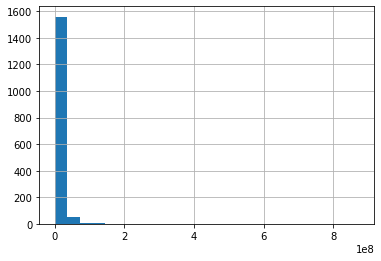

In [9]:
datas["SiteEnergyUse(kBtu)"].hist(bins=nb_classes * 2)


In [10]:
print(f"Skewness: {datas['SiteEnergyUse(kBtu)'].skew()}")
print(f"Kurtosis: {datas['SiteEnergyUse(kBtu)'].kurtosis()}")

Skewness: 17.73772610773084
Kurtosis: 431.2765888293235


Le skewness est supérieur à 0 donc la distribution de "SiteEnergyUse(kBtu)" est étalée à droite

Le kurtosis est supérieur à 0 donc la distribution de "SiteEnergyUse(kBtu)" est très concentrée

Je vais refaire les analyses après une normalisation de "SiteEnergyUse(kBtu)" par le log et comparer les résultats


Skewness: -1.1230031095285251
Kurtosis: 13.884343530544085


<AxesSubplot:>

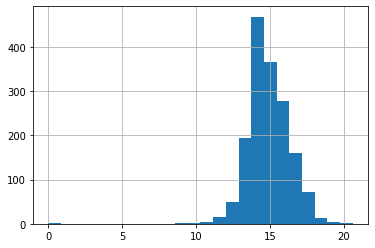

In [11]:
siteenergyuse_log = np.log(datas["SiteEnergyUse(kBtu)"] + 1)

print(f"Skewness: {siteenergyuse_log.skew()}")
print(f"Kurtosis: {siteenergyuse_log.kurtosis()}")

siteenergyuse_log.hist(bins=nb_classes * 2)


Skewness: 0   -0.061692
dtype: float64
Kurtosis: 0    0.883383
dtype: float64


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

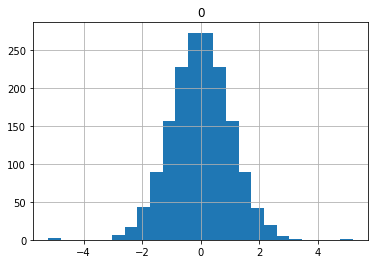

In [12]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution= "normal").fit(datas["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1))
siteenergy_qt = pd.DataFrame(qt.transform(datas["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)))

print(f"Skewness: {siteenergy_qt.skew()}")
print(f"Kurtosis: {siteenergy_qt.kurtosis()}")

siteenergy_qt.hist(bins=nb_classes * 2)

On peut constater que "SiteEnergyUse(kBtu)" mis au log a une distribution quasiment symétrique (skewness= -1.123) et une concentration beaucoup moindre (kurtosis à 13.884 au lieu de 431.276). Néanmoins, l'utilisation de la classe QuantileTransformer de sklearn est beaucoup plus probante car elle fournit une distribution normale (skewness= -0.062, kurtosis= 0.883)

On peut voir aussi sur l'histogramme transformé par le QuantileTransformer des valeurs s'apparentant à des outliers en dessous de -4 et au dessus de +4. Cependant, je vais fixer la valeur à 3 écart-types ce qui comprendra 99.7% des valeurs

### Conclusion

"SiteEnergyUse(kBtu)" sera transformé par QuantileTransformer pour la prédiction par souci d'uniformisation des données et les valeurs semblant être des outliers seront retirées

## "TotalGHGEmissions"

Skewness: 13.970997530041856
Kurtosis: 242.3213856508546


<AxesSubplot:>

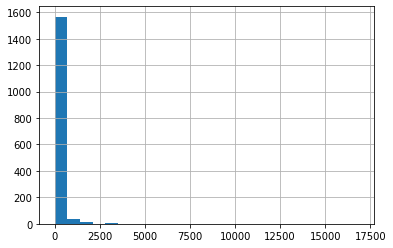

In [13]:
print(f"Skewness: {datas['TotalGHGEmissions'].skew()}")
print(f"Kurtosis: {datas['TotalGHGEmissions'].kurtosis()}")

datas["TotalGHGEmissions"].hist(bins=nb_classes * 2)


Le skewness est supérieur à 0 donc la distribution de "TotalGHGEmissions" est étalée à droite

Le kurtosis est supérieur à 0 donc la distribution de "TotalGHGEmissions" est très concentrée

Je vais refaire les analyses après une normalisation de "TotalGHGEmissions" par le log et comparer les résultats


Skewness: 0.2143540128389917
Kurtosis: 0.32740642732529057


<AxesSubplot:>

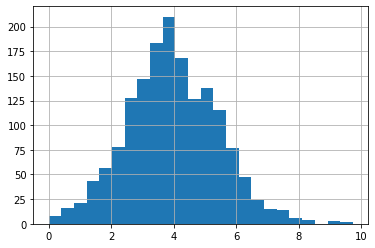

In [14]:
totalghg_log = np.log(datas["TotalGHGEmissions"] + 1)

print(f"Skewness: {totalghg_log.skew()}")
print(f"Kurtosis: {totalghg_log.kurtosis()}")

totalghg_log.hist(bins=nb_classes * 2)


Skewness: 0   -0.060252
dtype: float64
Kurtosis: 0    0.887448
dtype: float64


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

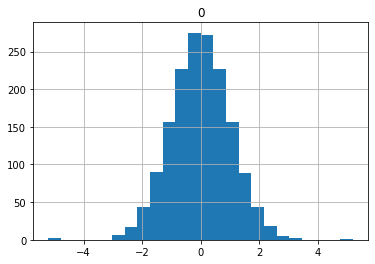

In [15]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution= "normal").fit(datas["TotalGHGEmissions"].to_numpy().reshape(-1, 1))
totalghg_qt = pd.DataFrame(qt.transform(datas["TotalGHGEmissions"].to_numpy().reshape(-1, 1)))

print(f"Skewness: {totalghg_qt.skew()}")
print(f"Kurtosis: {totalghg_qt.kurtosis()}")

totalghg_qt.hist(bins=nb_classes * 2)

De même que pour "SiteEnergyUse(kBtu), on peut constater que "TotalGHGEmissions" mis au log a une distribution quasiment symétrique (skewness= 0.214) et que son applatissement est quasiment le même que celui de la distribution normale (kurtosis= 0.327). Néanmoins, l'utilisation de QuantileTransformer rend la distribution parfaitement symétrique (skewness= -0.060) et le kurtosis augmente seulement de 0.6 dans le cas de l'utilisation de la classe sklearn. 

On peut voir des valeurs s'apparentant à des outliers en dessous de -4 et au dessus de +4. Tout comme ci-dessus, je fixe la limite des outliers à 3 écart-types.

### Conclusion

"TotalGHGEmissions" sera transformée par QuantileTransformer pour une meilleur uniformisation, il faudra aussi retirer les outliers.